# Import

In [44]:
from quspin.basis import spin_basis_1d,photon_basis,boson_basis_1d,tensor_basis # Hilbert space bases
from quspin.operators import hamiltonian # Hamiltonian and observables
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pylab
import scipy.sparse.linalg as sparseLA
from numpy import linalg as LA
from scipy.special import comb
import time

In [45]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] #colors for plotting

In [46]:
%matplotlib inline
#%matplotlib widget # uncomment for interactive plots in jupyter

# Hamiltonian of a two-state atom in a reservoir of harmonic oscillators 

For the purpose of our study, we take a two-level atom (i.e. a single-site spin chain) and couple it to multiple photon mode (i.e. a quantum harmonic oscillators). The Hamiltonian reads: 
$$ H = \sum_{k=1}^{N_{osc}} \Omega_k a_k^\dagger a_k + \frac{A}{2} \frac{1}{\sqrt{N_{ph~avg}}} \sum_k (a_k^\dagger + a_k) \sigma^x + \Delta \sigma^z$$
where the operator $a^\dagger$ creates a photon in the mode, and the atom is modelled by a two-level system described by the Pauli spin operators $\sigma^{x,y,z}$. 
<br> $N_{osc}$ - the number of harmonic oscillators in the reservoir,
<br> $N_{lev}$ - number of energy levels of an oscillator,
<br> $\Omega_k$ - array containing the frequencies of each oscillators,
<br> $N_{ph~avg}$ - the average number of photons in a single mode,
<br> $A$ - the coupling between the EM field $E=\sum_{k=1}^{N_{osc}}\sqrt{N_{ph~avg}^{-1}}(a_k^\dagger + a_k)$, and the dipole operator $\sigma^x$,
<br> $\Delta$ measures the energy difference between the two atomic states.

## Model parameters

In [47]:
# For the atom:
Delta=0.5 # difference between atom energy levels

In [57]:
# For the oscillators
N_osc=4 #number of harmonic oscillators
N_lev=4 # number of energy levels of oscillators
freq_delta = 0.1
# array of frequencies of oscillators is taken as a random vector with a uniform distribution 
Omega=np.random.uniform(1.0-freq_delta,1.0+freq_delta,N_osc) 
print(Omega)

[0.91768221 0.99285977 1.04158793 0.90264407]


In [58]:
# For the coupling
A=0.1 # spin-photon coupling strength 
N_ph_avg=N_lev//2

## Set-up operators for the Hamiltonian in QuSpin

To set up the spin-photon Hamiltonian, we first build the site-coupling lists. 
<br> Each oscillator is considered to be associated with a lattice site, so the "ph_energy" list contains the frequency array "Omega" and the corresponding lattice site index. 
<br> The "at_energy" list requires the input of the lattice site for the $\sigma^z$-operator (requirement of QuSpin).  Since we consider a single two-level system or, equivalently – a single-site chain, this index is 0. 
<br> The spin-photon coupling lists "absorb" and "emit" require the site indices for both atom (always 0) and oscillators.

In [8]:
# define operator site-coupling lists
ph_energy=[[Omega[i],i] for i in range(N_osc)] # photon energy
at_energy=[[Delta,0]] # atom energy, 0 because the "lattice" is single-site
absorb=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # absorption term
emit=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # emission term

To build the static operator list, we use the $|$ symbol in the operator string to distinguish the spin and photon operators: spin operators always come to the left of the $|$-symbol,  while photon operators - to the right. For convenience, the identity operator $I$ can be omitted, suchthat $I|n$ is the same as $|n$, and $z|I$ is equivalent to $z|$, respectively. 

In [71]:
# static operator without interaction between he atom and photons
static_no_interaction=[["|n",ph_energy],["z|",at_energy]]
# static operator with rotating-wave approximation
static_rotating_wave=[["|n",ph_energy],["+|-",absorb],["-|+",emit],["z|",at_energy]]
# static operator without rotating-wave approximation
static_full=[["|n",ph_energy],["x|-",absorb],["x|+",emit],["z|",at_energy]]

The dynamic list is empty since the spin-photon Hamiltonian is time-independent.

In [72]:
dynamic=[]

## Spin-photons mixed basis

Basis of scillators can be defined as a 1d bason-basis with L=N_osc - number of sites in the "lattice" and sps=N_lev (states per site)

In [73]:
basis_osc = boson_basis_1d(L=N_osc,sps=N_lev)

The atom basis can be defined as a 1 ad spin basis with a single site in the "lattice".

In [74]:
basis_spin = spin_basis_1d(L=1, pauli=-1, S="1/2")

The mixed atom-photons basis is created as a tensor product of boson-basis and spin-basis. It can be done with the "tensor_basis" class in QuSpin.

In [75]:
basis = tensor_basis(basis_spin,basis_osc) 
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
	  0.         |1>           1         |3 3 3 3>           255  
	  1.         |1>           1         |3 3 3 2>           254  
	  2.         |1>           1         |3 3 3 1>           253  
	  3.         |1>           1         |3 3 3 0>           252  
	  4.         |1>           1         |3 3 2 3>           251  
	  5.         |1>           1         |3 3 2 2>           250  
	  6.         |1>           1         |3 3 2 1>           249  
	  7.         |1>           1         |3 3 2 0>           248  
	  8.         |1>           1         |3 3 1 3>           247  
	  9.         |1>           1         |3 3 1 2>           246  
	 10.         |1>           1         |3 3 1 1>           245  
	 11.         |1>           1         |3 3 1 0>           244  
	 12.         |1>           1         |3 3 0 3>           243  
	 13.         |1>           1         |3 3 0 2>           242  
	 14.         |1>           1      

## Define atom-photon Hamiltonian H

Compute atom-photon Hamiltonians H for each of three cases (no interaction, rotating wave approximation, full interaction)

In [77]:
H_no_interaction=hamiltonian(static_no_interaction,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_full=hamiltonian(static_full,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_rotating_wave=hamiltonian(static_rotating_wave,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)

In [78]:
print('Number of states of Hamiltonian:', H_rotating_wave.Ns)

Number of states of Hamiltonian: 512


# Spectrum

Calculate the spectrum of the Hamiltonian without interaction:

In [84]:
start = time.time()
eigenvalues_H_no_interaction=H_no_interaction.eigvalsh()    # eigenvalsh gives only the eigenvalues (without eigenvectors)
end = time.time()
print('Runtime is', end-start)

Runtime is 0.02737879753112793


Calculate the spectrum of the Hamiltonian with full interaction:

In [85]:
start = time.time() 
eigenvalues_H_full=H_full.eigvalsh()    # eigenvalsh gives only the eigenvalues (without eigenvectors)
end = time.time()
print('Runtime is', end-start)

Runtime is 0.03536844253540039


In [86]:
start = time.time()
eigenvalues_H_rotating_wave, eigenvectors_H_rotating_wave = H_rotating_wave.eigh()        # eigh gives only the eigenvalues and eigenvectors (but does not use sparse matrices)
end = time.time()
print('Runtime is', end-start)

Runtime is 0.19190645217895508


Plot and compare spectra of all three Hamiltonians:

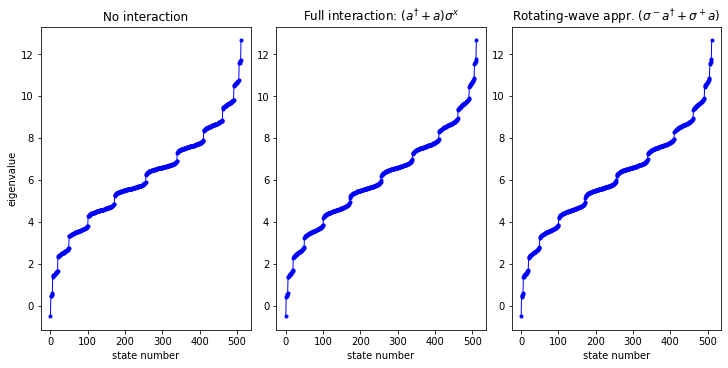

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))
x = np.arange(H_no_interaction.Ns)
ax[0].plot(x,eigenvalues_H_no_interaction, '.-', color='b', lw=1.)
ax[1].plot(x,eigenvalues_H_full, '.-', color='b', lw=1.)
ax[2].plot(x,eigenvalues_H_rotating_wave, '.-', color='b', lw=1.)
# for level in x :
#     ax[0].plot(x,np.full(H_no_interaction.Ns,eigenvalues_H_no_interaction[level]), '-', color='b', lw=0.5)
#     ax[1].plot(x,np.full(H_full.Ns,eigenvalues_H_full[level]), '-', color='b', lw=0.5)
#     ax[2].plot(x,np.full(H_rotating_wave.Ns,eigenvalues_H_rotating_wave[level]), '-', color='b', lw=0.5)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)
ax[1].set(title='Full interaction: $(a^\dag+a)\sigma^x$', xlabel='state number'); ax[1].grid(False)
ax[2].set(title='Rotating-wave appr. $(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[2].grid(False)
plt.show()

# Definitions: Block spectrum in the case rotating-wave approximation

Function giving the number of possble states in a 1d-boson basis with N_sites (number of oscillators in our case), with N_level states per site, and with a fixed numner of particles N_particles. Identical to the QuSpin implementation of boson basis, found in tutorial on Bose-Hubbard model in 1d https://weinbe58.github.io/QuSpin/examples/user-basis_example2.html#user-basis-example2-label . Requires import of function "comb" from scipy.special

In [19]:
# size of of the particle-conserved basis of bosons
def boson_block_size(N_sites, N_levels, N_particles):
    Ns=0
    for r in range(N_particles//N_levels+1):
        r_2 = N_particles - r*N_levels
        if r % 2 == 0:
            Ns +=  comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
        else:
            Ns += -comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
    return Ns

In the case of rotating-wave approximation the only transitions allowed are between the states with atom spin $\downarrow$ and $N$ photons and the states with spin $\uparrow$ and $N-1$ photons. Therefore, the sizes of smallest blocks, into which the spectrum can be divided, can be computed as sum of states in a boson-1d basis with $N$ particles and a boson-1d basis with $N-1$ particles:

In [89]:
def size_of_matrix_to_diagonalize_block(N_sites, N_levels, N_block):
    return boson_block_size(N_sites, N_levels, N_block-1)+boson_block_size(N_sites, N_levels, N_block)

In [90]:
size_of_matrix_to_diagonalize_block(10, 10, 10)

140988

Function returning the Hamiltonian matrix of a single block. 
<br>It requires as an argument the block's index (corresponds to number of particles that should be conseved in the interactions), ans static and dynamic lists to contruct Hamiltonian. It has an optional parameter "sparse" that changes to sperse representation of matrices (can be useful for large matrices). 
<br> It returns in addition the vector contating the indices of states in the same order as the full basis (the mixed atom-photons basis, called "basis" above), and the integer representations of the bosonic part of the Fock basis states corresponding to atom's spin up and spin down. 

In [92]:
def hamitonian_one_block(N_block, static_list, dynamic_list, sparse=False) :
    # generate projection of boson basis, where the number of particles is restricted to N_block and N_block-1:
    basis_osc_block = boson_basis_1d(L=N_osc, Nb={N_block,N_block-1}, sps=N_lev)    
    # mixed atom-boson basis - make tensor product with the atom spin basis, defined in the beginning of the notebook
    combined_basis_block = tensor_basis(basis_spin,basis_osc_block)  
    
    # the basis "combined_basis_block" is larger than the smallest necessary block, in the following it is reduced to the minimal possible block 

    # generate another projection of the boson basis with only N_block particles
    basis_osc_block_n = boson_basis_1d(L=N_osc, Nb={N_block}, sps=N_lev)     
    # Now find in the "basis_osc_block" indices of states with only N_block particles. The search is performed on the arrays of the integer representations of the bosonic Fock states.
    # The search can be done in the sorted array thanks to the lexicographic order of Fock states implemented in QuSpin
    # These states correspond to spin-down part of the block, and they all are in the second half of the "combined_basis_block", since QuSpin puts first all the states with spin up, and then with the spin down. 
    # The bosonic part of the mixed basis is arranged in the descending order.
    # We save the indices of these selected states with N particles in the second half of "combined_basis_block". These indices are needed further for reducind the size of the Hamiltonian matrix.
    selected_indices_n_down_spin = 2*len(basis_osc_block.states) - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n.states) - 1   
    # save the integer representations of the Fock states with N-particles for the function output
    boson_states_spin_down = np.copy(basis_osc_block_n.states)
    
    # Make the same but for a projection of bosonic basis with N-1 particles 
    basis_osc_block_n_minus_1 = boson_basis_1d(L=N_osc, Nb={N_block-1}, sps=N_lev)     # part of boson basis
    # Similarly, find indices of states with N_block-1 particles in basis_osc_block. These states correspond to spin-up part of the block.
    # We save the indices of these selected states with (N-1) particles in the FIRST half of "combined_basis_block". These indices are needed further for reducind the size of the Hamiltonian matrix.
    selected_indices_n_minus_1_up_spin = len(basis_osc_block.states) - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n_minus_1.states) - 1  
    # save the integer representations of the Fock states with (N-1)-particles for the function output
    boson_states_spin_up = np.copy(basis_osc_block_n_minus_1.states)
    
    # Glue up all the found indices in one vector
    all_selected_indices = np.concatenate((selected_indices_n_minus_1_up_spin, selected_indices_n_down_spin))  
    
    # build the Hamiltonian on the "combined_basis_block". It's called "full", since it includes some extra states and needs to be reduced
    if sparse :
        hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=combined_basis_block, check_symm=False, check_pcon=False, check_herm=False).tocsc()
    else :
        hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=combined_basis_block, check_symm=False, check_pcon=False, check_herm=False).toarray()
    
    # costruct the masking grid by using the found indices 
    ixgrid = np.ix_(all_selected_indices, all_selected_indices)
    # apply the mask to the Hamiltonian matrix: ir will remove the unnecessary row and columns from the matrix
    hamiltonian_reduced = hamiltonian_full[ixgrid]
    
    # compute the vector of the counters of state (needed to allow graphical comparison with the complete Hamiltonian)
    nb_of_prev_states = np.sum([(size_of_matrix_to_diagonalize_block(N_osc, N_lev, n)) for n in range(0,N_block)])
    states = np.arange(nb_of_prev_states+1*sparse, nb_of_prev_states+hamiltonian_reduced.shape[0])
    
    del hamiltonian_full, all_selected_indices, selected_indices_n_minus_1_up_spin, selected_indices_n_down_spin

    return hamiltonian_reduced, states, boson_states_spin_down, boson_states_spin_up

A wrapper for the eigenvalues/eigenvectors function of python, to allow simple switch between sparse and dense matrix representations:

In [23]:
def matrix_eigenvalues(matrix, sparse=False) :
    if sparse :
        eigenvals, eigenvectors = sparseLA.eigsh(matrix,k=matrix.shape[0]-1)
    else :
        eigenvals, eigenvectors = LA.eigh(matrix)   # for dense matrices
    return eigenvals, eigenvectors

A function combining computation of a Hamiltonian of a single block with the diagonalization:

In [24]:
def hamitonian_eigenvalues_one_block(N_block, static_list, dynamic_list) :
    if (size_of_matrix_to_diagonalize_block(N_osc, N_lev, N_block) < 1000) :
        sparse = False
    else :
        sparse = True  
    hamiltonian, states, boson_states_spin_down, boson_states_spin_up = hamitonian_one_block(N_block, static_list, dynamic_list, sparse)
    start = time.time()
    eigenvals, eigenvectors = matrix_eigenvalues(hamiltonian, sparse)
    end = time.time()
    print('N_photons=%2.0f, size of the reduced matrix=%2.0f, diagonalization runtime=%2.6e' % (N_block, len(eigenvals), (end-start))) 
    return eigenvals, eigenvectors, states, boson_states_spin_down, boson_states_spin_up

Function allowing one-line computation of all blocks of a Hamiltonian, and storing the data in dictionaries. Is returns an array of dictionaries. Each element(dictionary) of the array corresponds to one block.  

In [25]:
def get_all_blocks_hamiltonian_dictionary(static_list, dynamic_list) :
    blocks = [] 
    for N_block in range(0,(N_lev-1)*N_osc) : 
        b = dict()
        b['index_of_block'] = N_block
        b['eigenvals'], b['eigenvectors'], b['states'], b['boson_states_spin_down'], b['boson_states_spin_up'] = hamitonian_eigenvalues_one_block(N_block, static_list, dynamic_list)
        b['size'] = len(b['eigenvals'])
        blocks.append(b)
    return blocks

# Compute diagonalized blocks

In [26]:
blocks_no_interaction = get_all_blocks_hamiltonian_dictionary(static_no_interaction, dynamic)

N_photons= 0, size of the reduced matrix= 1, diagonalization runtime=7.510185e-05
N_photons= 1, size of the reduced matrix= 5, diagonalization runtime=1.165867e-04
N_photons= 2, size of the reduced matrix=14, diagonalization runtime=7.081032e-05
N_photons= 3, size of the reduced matrix=30, diagonalization runtime=8.296967e-05
N_photons= 4, size of the reduced matrix=51, diagonalization runtime=5.934238e-04
N_photons= 5, size of the reduced matrix=71, diagonalization runtime=2.844334e-03
N_photons= 6, size of the reduced matrix=84, diagonalization runtime=1.418114e-03
N_photons= 7, size of the reduced matrix=84, diagonalization runtime=1.176357e-03
N_photons= 8, size of the reduced matrix=71, diagonalization runtime=2.122879e-03
N_photons= 9, size of the reduced matrix=51, diagonalization runtime=4.262924e-04
N_photons=10, size of the reduced matrix=30, diagonalization runtime=9.131432e-05
N_photons=11, size of the reduced matrix=14, diagonalization runtime=1.187325e-04


In [27]:
blocks_rotating_wave = get_all_blocks_hamiltonian_dictionary(static_rotating_wave, dynamic)

N_photons= 0, size of the reduced matrix= 1, diagonalization runtime=6.890297e-05
N_photons= 1, size of the reduced matrix= 5, diagonalization runtime=1.435280e-04
N_photons= 2, size of the reduced matrix=14, diagonalization runtime=2.393723e-04
N_photons= 3, size of the reduced matrix=30, diagonalization runtime=5.879402e-04
N_photons= 4, size of the reduced matrix=51, diagonalization runtime=1.644492e-02
N_photons= 5, size of the reduced matrix=71, diagonalization runtime=2.290487e-03
N_photons= 6, size of the reduced matrix=84, diagonalization runtime=2.818823e-03
N_photons= 7, size of the reduced matrix=84, diagonalization runtime=2.297640e-03
N_photons= 8, size of the reduced matrix=71, diagonalization runtime=1.704216e-03
N_photons= 9, size of the reduced matrix=51, diagonalization runtime=1.028538e-03
N_photons=10, size of the reduced matrix=30, diagonalization runtime=5.092621e-04
N_photons=11, size of the reduced matrix=14, diagonalization runtime=1.959801e-04


# Compare spectrum of blocks with the full one

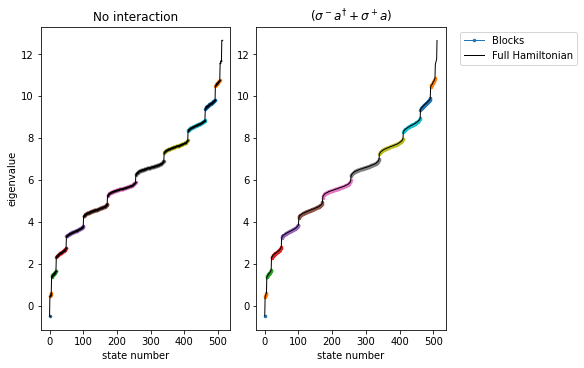

In [28]:
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(8,5))

#no interation
for i,b in enumerate(blocks_no_interaction) :
    ax[0].plot(b['states'], b['eigenvals'], '.-', lw=1., ms=5.0)
ax[0].plot(np.arange(H_no_interaction.Ns),eigenvalues_H_no_interaction, '.-', color='k', lw=1., ms=1.0)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue');

# rotating wave approx
for i,b in enumerate(blocks_rotating_wave) :
    ax[1].plot(b['states'], b['eigenvals'], '.-', lw=1., ms=5.0, label=('Blocks' if i==0 else ''))
ax[1].plot(eigenvalues_H_rotating_wave, '-', color='k', lw=1., ms=1.0, label='Full Hamiltonian')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); 
plt.show()

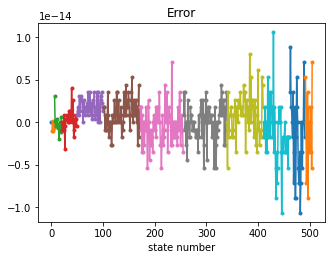

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
for i, block in enumerate(blocks_rotating_wave) :
    x = np.array(block['states'], dtype=int)
    ax.plot(x, block['eigenvals']-eigenvalues_H_rotating_wave[x], '.-')
ax.set(title='Error', xlabel='state number')
plt.show()

In [30]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
# N_block={3,4,5}
# for i in N_block :  
#     ax.plot(blocks_rotating_wave[i]['states'], blocks_rotating_wave[i]['eigenvals'], '.-')
# ax.set(title=r'Three blocks $N_b$=' + str(N_block), xlabel='state number', ylabel='eigenvalue'); ax.grid()
# plt.show()

In [31]:
# for i, block in enumerate(blocks_rotating_wave[4:5]) :
#     for state in block['boson_states_spin_up'] :
#         print(basis_osc.int_to_state(state))

In [32]:
# for i, block in enumerate(blocks_rotating_wave[4:5]) :
#     for state in block['boson_states_spin_down'] :
#         print(basis_osc.int_to_state(state))

# Observables computed from eigenvectors

In [33]:
def get_occupancy_on_site(site_index_array, state_int_array, sps) :
    xx, yy = np.meshgrid(site_index_array, state_int_array, indexing='ij')
    return (yy//sps**xx)%sps

Computation of observables : long version with loops

In [34]:
# for i, block in enumerate(blocks_rotating_wave) :
#     # collect integer representations of the fock states of bosonic part of reduced block basis
#     state_integers = np.concatenate((block['boson_states_spin_up'], block['boson_states_spin_down']))
#     # mean occupancy and its fluctuation at each site of the photon-lattice
#     block['ni_mean'] = np.zeros([N_osc, block['size']]); block['ni_fluct'] = np.zeros([N_osc, block['size']])
    
#     for site_index in range(N_osc) : 
#         mean = np.zeros(block['size']); mean_sqr = np.zeros(block['size'])
#         for eigenvector_index, eigenvector in enumerate(block['eigenvectors'].T) : # loop over matrix columns
#             block['ni_mean'][site_index, eigenvector_index] = np.sum(get_occupancy_on_site(site_index,state_integers,N_lev)*eigenvector**2)
#             block['ni_fluct'][site_index, eigenvector_index] = np.sum((get_occupancy_on_site(site_index,state_integers,N_lev)**2)*eigenvector**2)
#     block['ni_fluct'] = block['ni_fluct'] - block['ni_mean']**2

#     # average atom spin
#     spins = 0.5*np.concatenate((np.full(len(block['boson_states_spin_up']),1.), np.full(len(block['boson_states_spin_down']),-1.))) 
#     block['spin_mean'] = np.zeros(block['size'])
#     for eigenvector_index, eigenvector in enumerate(block['eigenvectors'].T) : # loop over matrix columns        
#         block['spin_mean'][eigenvector_index] = np.sum(spins*eigenvector**2)

The same computation, but with the use of python numpy dot product function instead of "for"-loops  :

In [35]:
for i, block in enumerate(blocks_rotating_wave) :
    state_integers = np.concatenate((block['boson_states_spin_up'], block['boson_states_spin_down']))
    
    # mean occupancy and its fluctuation at each site of the photon-lattice
    block['ni_mean'] = np.dot(get_occupancy_on_site(range(N_osc),state_integers,N_lev),(block['eigenvectors']**2))
    block['ni_fluct'] = np.dot((get_occupancy_on_site(range(N_osc),state_integers,N_lev)**2),(block['eigenvectors']**2)) - block['ni_mean']**2
    
    # average atom spin
    spins = np.concatenate((np.full(len(block['boson_states_spin_up']),1.), np.full(len(block['boson_states_spin_down']),-1.))) 
    block['spin_mean'] = np.dot(spins, block['eigenvectors']**2)

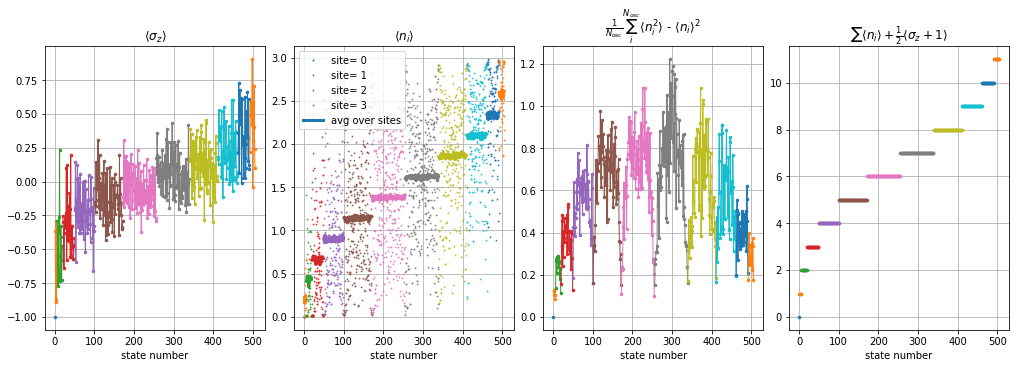

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(14,5))

for i, block in enumerate(blocks_rotating_wave) :
    block_color = colors[i%len(colors)]
    ax[0].plot(block['states'], block['spin_mean'], '.-', lw=1., ms=5.0, color=block_color)
    for site in range(N_osc) :
        ax[1].plot(block['states'], block['ni_mean'][site,:], marker=Line2D.filled_markers[site], lw=0, ms=1., color=block_color, label='site=%2.0f'%site)
    ax[1].plot(block['states'], np.mean(block['ni_mean'], axis=0), '-', lw=3., color=block_color, label='avg over sites')
    if i==0 : ax[1].legend()
    ax[2].plot(block['states'], np.mean(block['ni_fluct'], axis=0), '.-', lw=1., ms=5.0, color=block_color)
    ax[3].plot(block['states'], np.sum(block['ni_mean'][:,:], axis=0) + 0.5*(block['spin_mean']+1), '.-', lw=1., ms=5.0)
ax[0].set(title=r'$\langle \sigma_z \rangle$', xlabel='state number'); ax[0].grid()
ax[1].set(title=r'$\langle n_i \rangle$', xlabel='state number'); ax[1].grid()
ax[2].set(title=r'$\frac{1}{N_{osc}}\sum_{i}^{N_{osc}}\langle n_i^2 \rangle$ - $\langle n_i \rangle^2$', xlabel='state number'); ax[2].grid()
ax[3].set(title=r'$\sum \langle n_i \rangle + \frac{1}{2} \langle \sigma_z + 1\rangle$', xlabel='state number'); ax[3].grid()
plt.show()

# Matrices of operators

## Operators applied to the full Hamiltonian basis

In [37]:
sigma_z_operator_full = hamiltonian([["z|",[[1.,0]]]],[],dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
n_operator_full = hamiltonian([["|n",[[1.,i] for i in range(N_osc)]]],[],dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)

mean_full_sigma_z = sigma_z_operator_full.expt_value(eigenvectors_H_rotating_wave, enforce_pure=True)
mean_full_n = n_operator_full.expt_value(eigenvectors_H_rotating_wave, enforce_pure=True)

## Operators applied to block basis

In [38]:
for i, block in enumerate(blocks_rotating_wave) :
    block['sigma_z_operator_matrix'] = hamitonian_one_block(block['index_of_block'], [["z|",[[1.,0]]]], [], sparse=False)[0]
    block['n_operator_matrix'] = hamitonian_one_block(block['index_of_block'], [["|n",[[1.,i] for i in range(N_osc)]]], [], sparse=False)[0]
    block['mean_sigma_z_operator_matrix'] = np.empty(block['size'])
    block['mean_n_operator_matrix'] = np.empty(block['size'])
    for state_index, eigenvector in enumerate(block['eigenvectors'].T) :    # loop over eigenvectors (matrix columns)
        block['mean_sigma_z_operator_matrix'][state_index] = np.dot(eigenvector.T, np.dot(block['sigma_z_operator_matrix'],eigenvector))
        block['mean_n_operator_matrix'][state_index] = np.dot(eigenvector.T, np.dot(block['n_operator_matrix'],eigenvector))

# Plot and compare

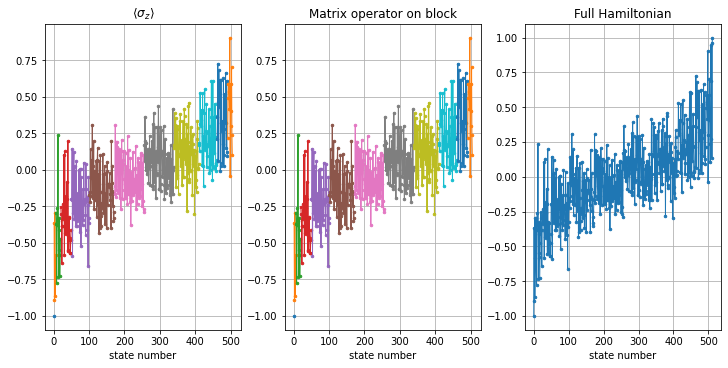

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))

for i, block in enumerate(blocks_rotating_wave) :
    ax[0].plot(block['states'], block['spin_mean'], '.-', lw=1., ms=5.0)
    ax[1].plot(block['states'], block['mean_sigma_z_operator_matrix'], '.-', lw=1., ms=5.0)
# ax[0].plot(mean_full_sigma_z, '-', lw=0.5, color='k')
# ax[1].plot(mean_full_sigma_z, '-', lw=0.5, color='k')
ax[2].plot(mean_full_sigma_z, '.-', lw=1., ms=5.0)
ax[0].set(title=r'$\langle \sigma_z \rangle$', xlabel='state number'); ax[0].grid()
ax[1].set(title='Matrix operator on block', xlabel='state number'); ax[1].grid()
ax[2].set(title='Full Hamiltonian', xlabel='state number'); ax[2].grid()
plt.show()

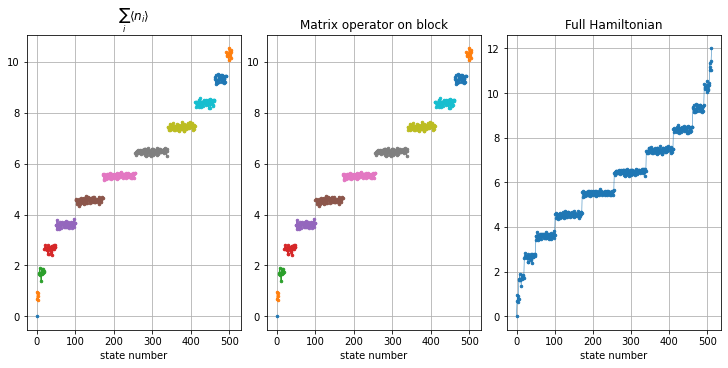

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))

for i, block in enumerate(blocks_rotating_wave) :
    ax[0].plot(block['states'], np.sum(block['ni_mean'], axis=0), '.-', lw=1., ms=5.0)
    ax[1].plot(block['states'], block['mean_n_operator_matrix'], '.-', lw=1., ms=5.0)
# ax[0].plot(mean_full_n, '-', lw=0.5, color='k')
# ax[1].plot(mean_full_n, '-', lw=0.5, color='k')
ax[2].plot(mean_full_n, '.-', lw=0.5, ms=5.0)
ax[0].set(title=r'$\sum_i \langle n_i \rangle$', xlabel='state number'); ax[0].grid()
ax[1].set(title='Matrix operator on block', xlabel='state number'); ax[1].grid()
ax[2].set(title='Full Hamiltonian', xlabel='state number'); ax[2].grid()
plt.show()

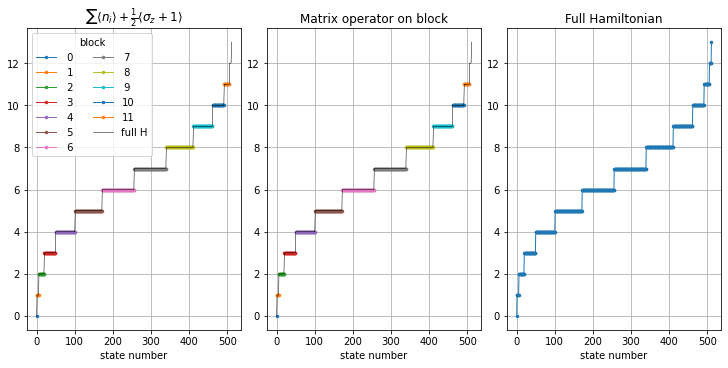

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))

for i, block in enumerate(blocks_rotating_wave) :
    ax[0].plot(block['states'], np.sum(block['ni_mean'][:,:], axis=0) + 0.5*(block['spin_mean']+1), '.-', lw=1., ms=5.0, label='%2.0f'%i)
    ax[1].plot(block['states'], block['mean_n_operator_matrix'] + 0.5*(block['mean_sigma_z_operator_matrix']+1), '.-', lw=1., ms=5.0)
ax[0].plot(mean_full_n + 0.5*(mean_full_sigma_z+1), '-', lw=0.5, color='k', label='full H')
ax[1].plot(mean_full_n + 0.5*(mean_full_sigma_z+1), '-', lw=0.5, color='k')
ax[2].plot(mean_full_n + 0.5*(mean_full_sigma_z+1), '.-', lw=1., ms=5.0)
ax[0].set(title=r'$\sum \langle n_i \rangle + \frac{1}{2} \langle \sigma_z + 1\rangle$', xlabel='state number'); ax[0].grid()
ax[0].legend(title='block', ncol=2)
ax[1].set(title='Matrix operator on block', xlabel='state number'); ax[1].grid()
ax[2].set(title='Full Hamiltonian', xlabel='state number'); ax[2].grid()
plt.show()

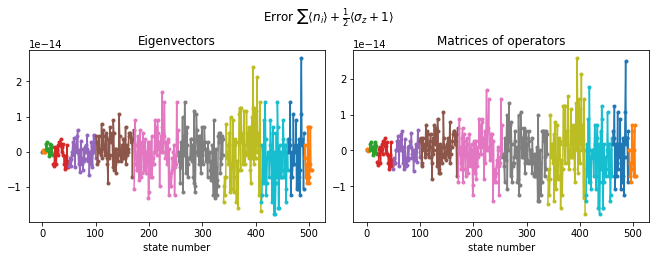

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(9,3.5))
fig.suptitle(r'Error $\sum \langle n_i \rangle + \frac{1}{2} \langle \sigma_z + 1\rangle$')
for i, block in enumerate(blocks_rotating_wave) :
    x = np.array(block['states'], dtype=int)
    ax[0].plot(x, np.sum(block['ni_mean'][:,:], axis=0) + 0.5*(block['spin_mean']+1)- (mean_full_n[x] + 0.5*(mean_full_sigma_z[x]+1)), '.-')
    ax[1].plot(x, block['mean_n_operator_matrix'] + 0.5*(block['mean_sigma_z_operator_matrix']+1)- (mean_full_n[x] + 0.5*(mean_full_sigma_z[x]+1)), '.-')
ax[0].set(title='Eigenvectors', xlabel='state number')
ax[1].set(title='Matrices of operators', xlabel='state number')
plt.show()